In [1]:
import warnings 
warnings.filterwarnings('ignore')

# basic libraries
import os
import numpy as np
import pandas as pd


# visulaization modules
import missingno as msnoz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Common model helpers
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, auc, 
                             precision_score,
                             recall_score,
                             f1_score,classification_report)

from sklearn.model_selection import (GridSearchCV,
                                     StratifiedKFold,
                                     cross_val_score)

# imbalance dataset handling
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     EditedNearestNeighbours,
                                     NearMiss)

from imblearn.over_sampling import (SMOTE,
                                    ADASYN)
# Model algorithims
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn .ensemble import RandomForestClassifier 

In [2]:
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')
stroke2 = stroke.copy()

In [3]:
stroke2.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


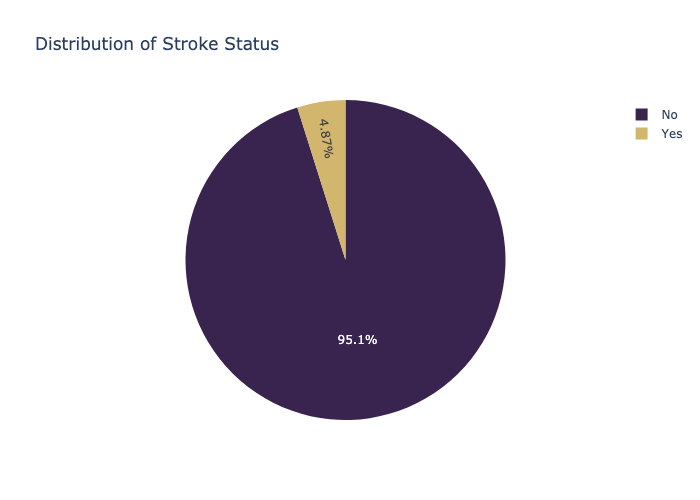

In [4]:
stroke2['stroke'] = stroke2['stroke'].replace({1: 'Yes', 0: 'No'})
stroke_counts = stroke2['stroke'].value_counts().reset_index()
stroke_counts.columns = ['stroke', 'count']
custom_colors = ['#39244F', '#D3B66E'] 

fig = px.pie(stroke_counts, names='stroke', values='count',
             title='Distribution of Stroke Status',
             color_discrete_sequence=custom_colors)

fig.show('png')

The pie chart visually represents the distribution of stroke cases within the dataset, effectively categorizing them into "No Stroke" and "Stroke" categories. As you can see their is an imbalance between ‘Stroke’ and ‘No Stroke’ cases. The small cases of ‘Stroke’ cases in comparison will lead to a prediction that will have issues with accuracy if not corrected.

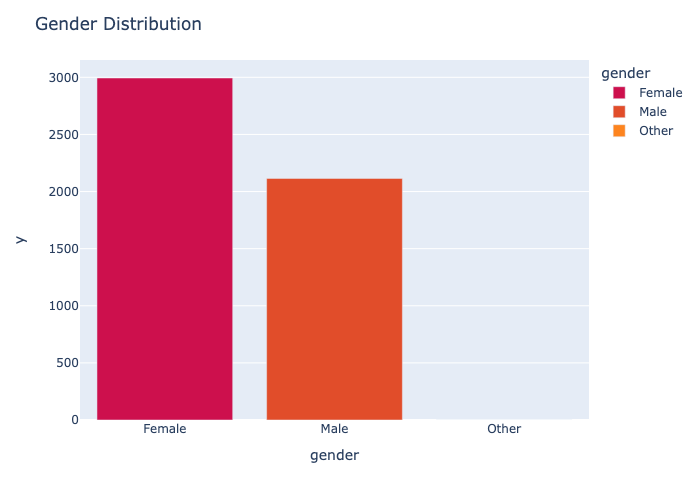

In [5]:

gender_counts = stroke2['gender'].value_counts()
custom_colors = ['#CD104D' , '#E14D2A',  '#FD841F'] 

fig1 = px.bar(gender_counts, x=gender_counts.index, y=gender_counts.values, color=gender_counts.index,
              color_discrete_map={gender: color for gender, color in zip(gender_counts.index, custom_colors)})
fig1.update_layout(title='Gender Distribution')
fig1.show('png')

The bar chart visualize the higher 'Female' showing in the dataset than their 'Male' counterparts. Which make female the more dominate gender category.

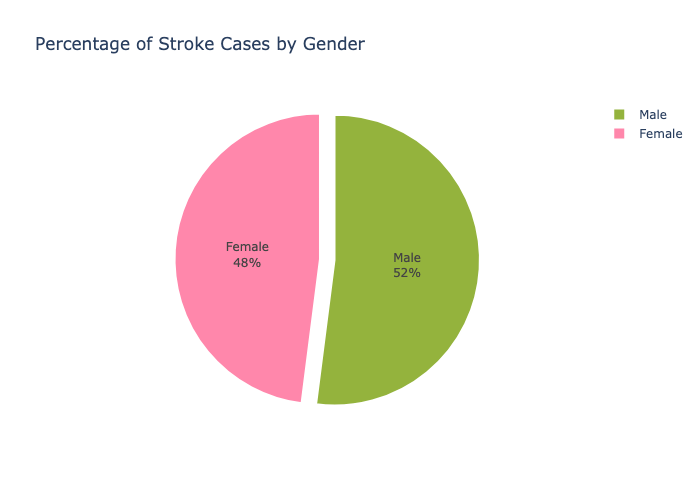

In [6]:
gender_stroke_counts = stroke.groupby(['gender', 'stroke']).size().unstack()
gender_stroke_percentage = (gender_stroke_counts[1] / (gender_stroke_counts[0] + gender_stroke_counts[1])) * 100

fig = px.pie(names=gender_stroke_percentage.index, values=gender_stroke_percentage.values,
             title="Percentage of Stroke Cases by Gender",
             color_discrete_sequence=['#94b33d','#ff87ab'])

fig.update_traces(textinfo="percent+label", pull=[0.1, 0], marker=dict(line=dict(color="white", width=2)))
fig.show('png')

The chart represent the percentage of stroke cases for each gender. Even though their are more 'Females' repesented in the dataset 'Males' are still ahead when it comes to stroke cases at 52% while 'Females' are at 48%.

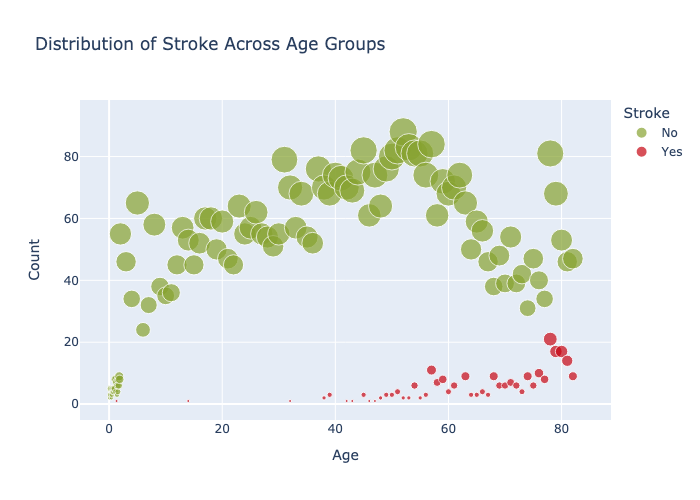

In [7]:
age_stroke_counts = stroke2.groupby(['age', 'stroke']).size().reset_index(name= 'Count')
fig_bubble_age_stroke = px.scatter(age_stroke_counts, x="age", y="Count", size="Count", color="stroke",
                                   title="Distribution of Stroke Across Age Groups",
                                   labels={"age": "Age", "Count": "Count", "stroke": "Stroke"},
                                   color_discrete_sequence=['#87a330', '#c70512'] )

fig_bubble_age_stroke.update_layout(xaxis_title="Age", yaxis_title="Count")
fig_bubble_age_stroke.show('png')

Being represented on the scatter chart are the different counts of strokes in each age ground. The size of the circles shows the value and larger the greater the value and vise versa. What you can get from this chart is that in the later age groups the risk for strokes increases.

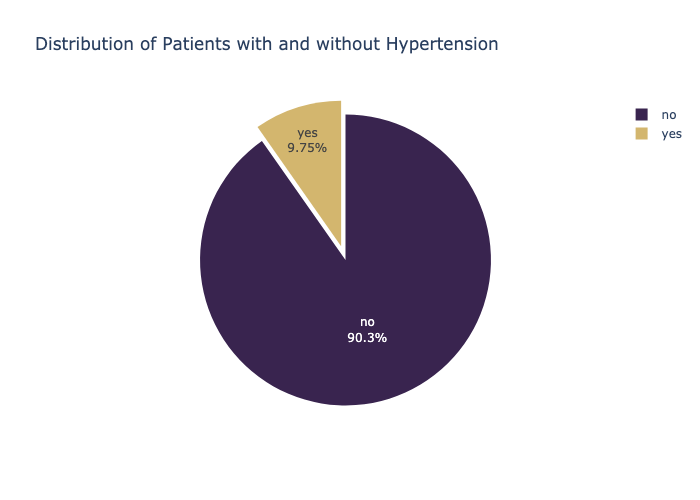

In [8]:
stroke2['hypertension'] = stroke2['hypertension'].replace({1:'yes', 0:'no'})
hypertension_count = stroke2['hypertension'].value_counts()
custom_colors = ['#39244F', '#D3B66E'] 

fig = px.pie(
    values=hypertension_count,
    names=hypertension_count.index,
    title='Distribution of Patients with and without Hypertension',
    color_discrete_sequence=custom_colors,  
)

fig.update_traces(textinfo='percent+label', pull=[0, 0.1])
fig.show('png')

Many of the patients don't have hypertension with the 'No' category accounting for 90.3% percent. While the 'Yes' category only accounted for 9.75% of the patients.

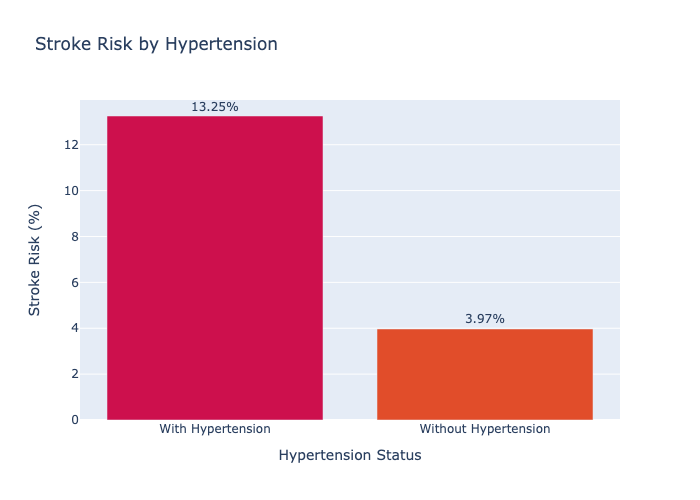

In [9]:
stroke_risk_with_hypertension = (stroke[stroke['hypertension'] == 1]['stroke'].mean()) * 100
stroke_risk_without_hypertension = (stroke[stroke['hypertension'] == 0]['stroke'].mean()) * 100

data = pd.DataFrame({'Hypertension': ['With Hypertension', 'Without Hypertension'],
                     'Stroke Risk': [stroke_risk_with_hypertension, stroke_risk_without_hypertension]})

fig = px.bar(data, x='Hypertension', y='Stroke Risk',
             text='Stroke Risk', title='Stroke Risk by Hypertension',
             labels={'Hypertension': 'Hypertension Status', 'Stroke Risk': 'Stroke Risk (%)'})

fig.update_traces(marker_color=['#CD104D' , '#E14D2A'])
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.show('png')

The bar graph shows that if you have hypertension you would have an increase risk of a stroke

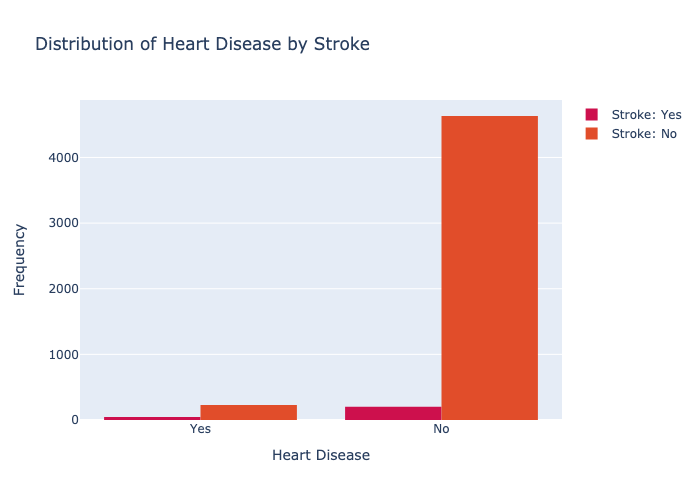

In [10]:
stroke2['heart_disease'] = stroke2['heart_disease'].replace({1:'Yes', 0:'No'})
yes_heart_disease = stroke2[stroke2['stroke'] == 'Yes']['heart_disease']
no_heart_disease = stroke2[stroke2['stroke'] == 'No']['heart_disease']

heart_disease_data = [yes_heart_disease, no_heart_disease]

group_labels_heart_disease = ["Stroke: Yes", "Stroke: No"]
colors_heart_disease = ['#CD104D' , '#E14D2A'] 

fig_heart_disease = go.Figure()
for i in range(2):
    fig_heart_disease.add_trace(go.Histogram(x=heart_disease_data[i], nbinsx=10, opacity=1, name=group_labels_heart_disease[i], marker_color=colors_heart_disease[i]))

fig_heart_disease.update_layout(title="Distribution of Heart Disease by Stroke",
                                xaxis_title="Heart Disease", yaxis_title="Frequency")
fig_heart_disease.show('png')


The data suggest that heart disease dosent impact wether your risk of a stroke will increase

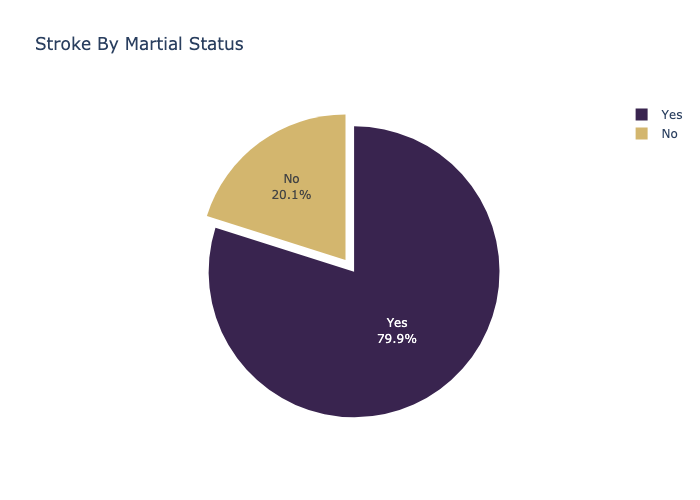

In [11]:
ever_married = stroke2.groupby('ever_married')['stroke'].value_counts(normalize=True).unstack().reset_index()
custom_colors = ['#39244F', '#D3B66E'] 

fig = px.pie(ever_married, values='Yes', names='ever_married', title = 'Stroke By Martial Status', color_discrete_sequence=custom_colors)

fig.update_traces(textinfo='percent+label', pull=[0,0.1])
fig.show('png')

The graph shows stroke case among patients who were ever married versus those who were not.

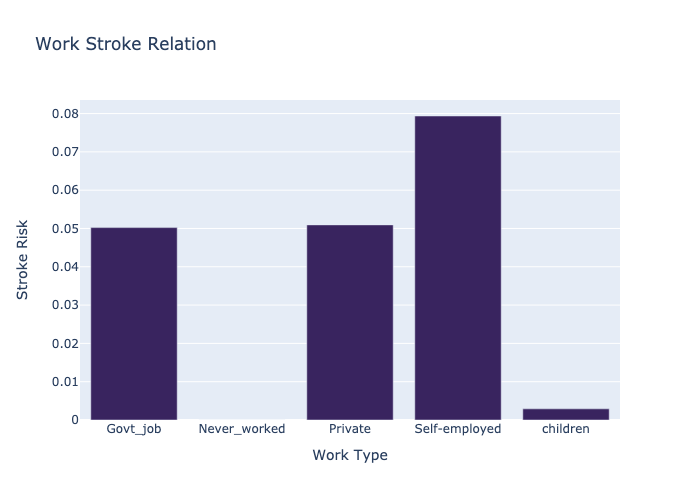

In [12]:
Work_Stroke_Relation = stroke.groupby('work_type')['stroke'].mean().reset_index()
color = ['#39245F']

fig = px.bar(Work_Stroke_Relation, x="work_type", y='stroke', title="Work Stroke Relation", color_discrete_sequence = color)
fig.update_layout(xaxis_title="Work Type", yaxis_title="Stroke Risk")
fig.show('png')

The data shows that the type of job impacts your risk level linking the two having a 'Self-employed' is a big factor in wether there is a likeliness of increase in stroke risk.

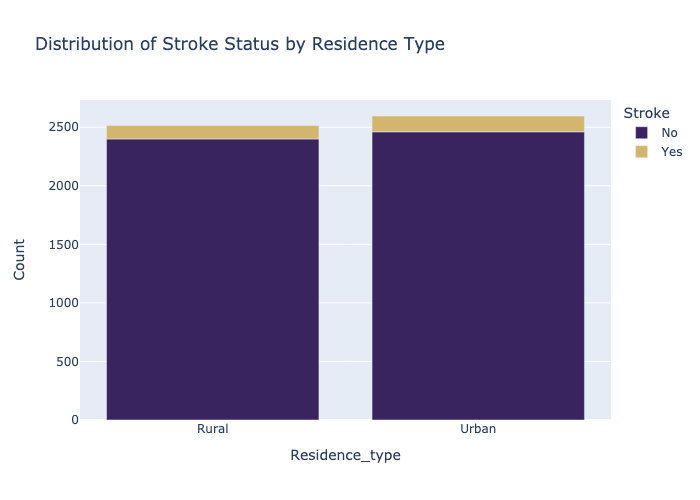

In [13]:
residence_stroke_counts = stroke2.groupby(['Residence_type', 'stroke']).size().unstack().reset_index()
residence_stroke_counts.columns = ['Residence_type', 'No', 'Yes']

custom_colors =['#39245F', '#D3B66E'] 
fig = px.bar(residence_stroke_counts, x='Residence_type', y=['No', 'Yes'],
             title='Distribution of Stroke Status by Residence Type',
             color_discrete_sequence=custom_colors,
             labels={'variable': 'Stroke', 'value': 'Count'},
             )
fig.show('png')

The diagram show that there are more stroke patients in urban areas compared to rural areas.

In [14]:
print(stroke2['avg_glucose_level'].min())
print(stroke2['avg_glucose_level'].max())

glucose_lvl = [55.12,100,126,271.74]
glucose_labels = ['Normal', 'Prediabetes', 'Diabetes']

stroke2['avg_glucose_level_group'] = pd.cut(stroke2['avg_glucose_level'], bins=glucose_lvl, labels=glucose_labels, right=False)

print(stroke2[['avg_glucose_level', 'avg_glucose_level_group']].head())

55.12
271.74
   avg_glucose_level avg_glucose_level_group
0             228.69                Diabetes
1             202.21                Diabetes
2             105.92             Prediabetes
3             171.23                Diabetes
4             174.12                Diabetes


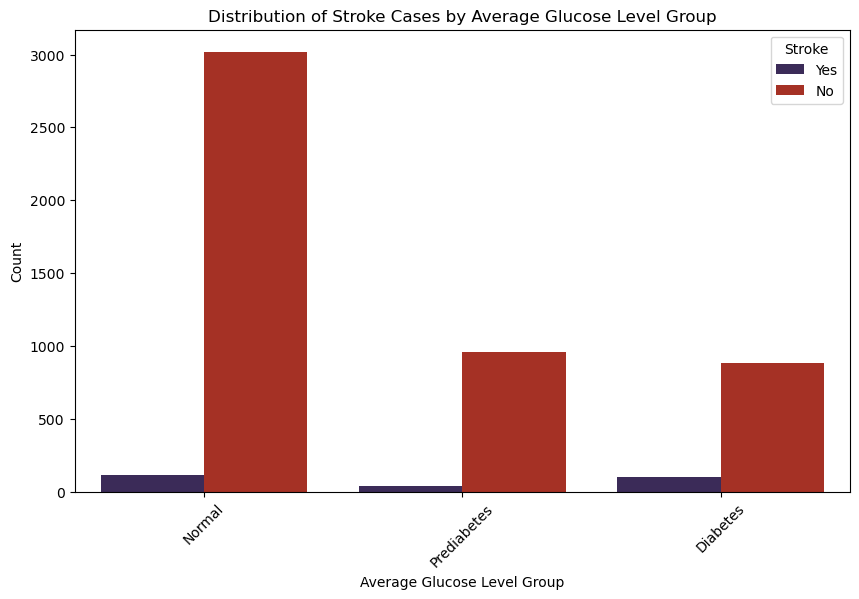

In [15]:
plt.figure(figsize=(10,6))
custom_color = ['#39245F', '#Ba2010']

ax = sns.countplot(data=stroke2, x='avg_glucose_level_group', hue='stroke', palette=custom_color)

plt.title("Distribution of Stroke Cases by Average Glucose Level Group")
plt.xlabel("Average Glucose Level Group")
plt.ylabel("Count")
plt.legend(title="Stroke", labels=["Yes", "No"])
plt.xticks(rotation=45)
plt.show()

When looking at Normal, Prediabetes, and Diabetes levels of glucose levels we can suggest two things either the data is uneven when it comes to participants with a certain glucose levels no being represented well or the glucose level have little effect on the probability of getting a stroke.

In [16]:
print(stroke2['bmi'].min())
print(stroke2['bmi'].max())

bmi_lvl = [10.3,18.5,24.9,29.9,30.0,35,40,97.6]
bmi_labels = ['Underweight', 'Healthy Weight', 'Overweight', 'Obese', 'Class 1 Obesity', 'Class 2 Obesity', 'Class 3 Obesity']

stroke2['bmi_lvl_group'] = pd.cut(stroke2['bmi'], bins=bmi_lvl, labels=bmi_labels, right=False)

print(stroke2[['bmi', 'bmi_lvl_group']].head())

10.3
97.6
    bmi    bmi_lvl_group
0  36.6  Class 2 Obesity
1   NaN              NaN
2  32.5  Class 1 Obesity
3  34.4  Class 1 Obesity
4  24.0   Healthy Weight


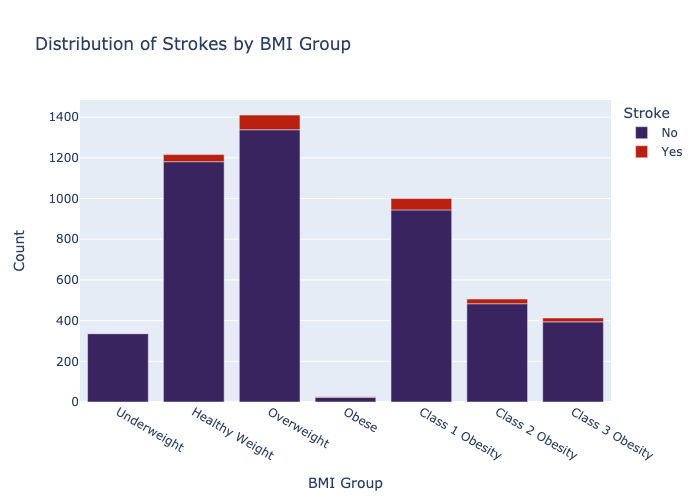

In [17]:
bmi_stroke_counts = stroke2.groupby(['bmi_lvl_group', 'stroke']).size().reset_index(name='Count')

fig = px.bar(bmi_stroke_counts, x='bmi_lvl_group', y='Count', color='stroke',
             title='Distribution of Strokes by BMI Group',
             labels={'bmi_group': 'BMI Group', 'Count': 'Count', 'stroke': 'Stroke'},
             color_discrete_sequence=['#39245F', '#Ba2010'] )
fig.update_layout(xaxis_title='BMI Group', yaxis_title='Count', legend_title='Stroke')
fig.show('png')

The graph dosen't show dramatically the affects of increase weight gain but as we do know from common knowledge that being over the recommeded weight will increase your chance of heart disease.

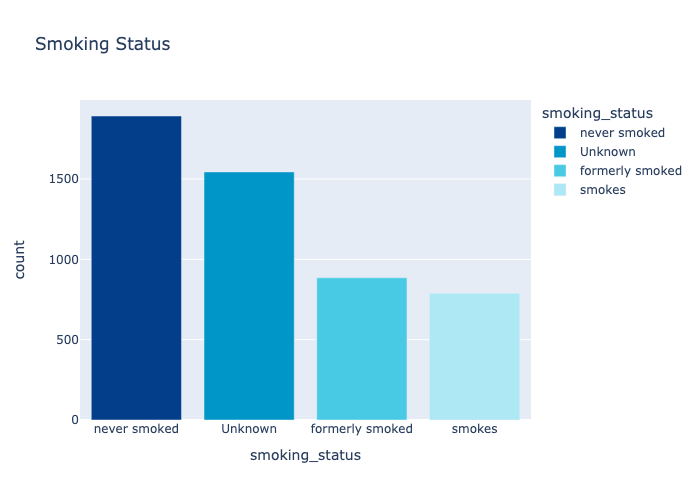

In [18]:
smoking_status = stroke2['smoking_status'].value_counts().reset_index()
custom_colors = ['#023e8a', '#0096c7', '#48cae4', '#ade8f4']

fig = px.bar(smoking_status, x='smoking_status', y='count', 
             title = 'Smoking Status', color = 'smoking_status', 
             color_discrete_sequence = custom_colors)
fig.show('png')

Looking at the chart majority of patients have never smokes while a small few still smokes.

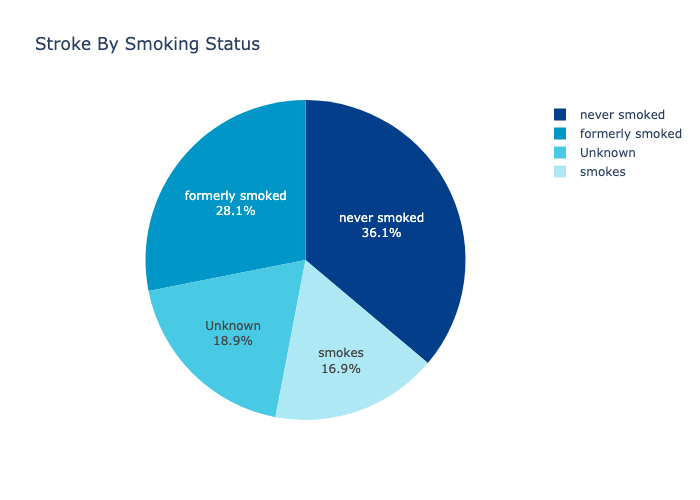

In [19]:
smoke_status_stroke_count = stroke2.groupby(['smoking_status', 'stroke']).size().unstack().fillna(0).reset_index()
custom_colors = ['#023e8a', '#0096c7', '#48cae4', '#ade8f4']

fig = px.pie(smoke_status_stroke_count, values='Yes', names='smoking_status', title = 'Stroke By Smoking Status', color_discrete_sequence=custom_colors)

fig.update_traces(textinfo='percent+label')
fig.show('png')

The diagrams give us the information that smoking dosen't having a correlation to stroke seeing that majority of people who had strokes never smoked before while the patients who were currenlty still in the habit of smoking had far less strokes recorded.

In [20]:
stroke.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [21]:
nan_values = stroke['bmi'].dropna() 
sampled_values = np.random.choice(nan_values, size=stroke['bmi'].isnull().sum(), replace=True)
stroke.loc[stroke['bmi'].isnull(), 'bmi'] = sampled_values
stroke.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [22]:
stroke['smoking_status'].replace('Unknown', np.nan, inplace=True)

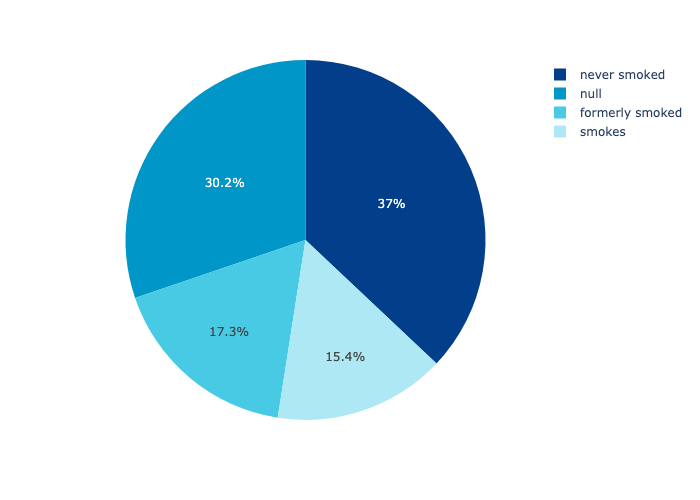

In [23]:
custom_colors = ['#023e8a', '#0096c7', '#48cae4', '#ade8f4']
fig = px.pie(stroke, names = 'smoking_status', color_discrete_sequence = custom_colors)
fig.show('png')

In [24]:
smoking_nan_values = stroke['smoking_status'].dropna() 
sampled_values = np.random.choice(smoking_nan_values, size=stroke['smoking_status'].isnull().sum(), replace=True)
stroke.loc[stroke['smoking_status'].isnull(), 'smoking_status'] = sampled_values

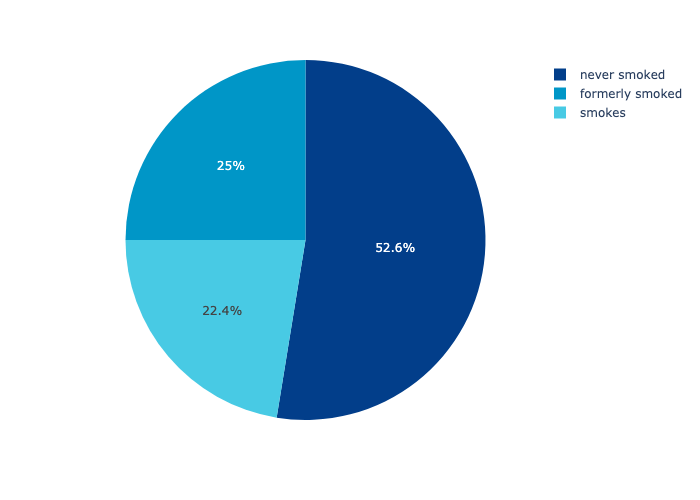

In [25]:
custom_colors = ['#023e8a', '#0096c7', '#48cae4', '#ade8f4']
fig = px.pie(stroke, names = 'smoking_status', color_discrete_sequence = custom_colors)
fig.show('png')

In [26]:
stroke.drop_duplicates()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,20.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,23.5,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [27]:
stroke = stroke[(stroke['gender'] != 'Other')]

In [28]:
stroke['gender'] = stroke['gender'].str.replace('Male', '1')
stroke['gender'] = stroke['gender'].str.replace('Female', '0')
stroke['gender'] = stroke['gender'].astype('int32')

In [29]:
stroke['ever_married'] = stroke['ever_married'].str.replace('Yes', '1')
stroke['ever_married'] = stroke['ever_married'].str.replace('No', '0')
stroke['ever_married'] = stroke['ever_married'].astype('int32')

In [30]:
stroke['Residence_type'] = stroke['Residence_type'].str.replace('Urban', '1')
stroke['Residence_type'] = stroke['Residence_type'].str.replace('Rural', '0')
stroke['Residence_type'] = stroke['Residence_type'].astype('int32')

In [31]:
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,0,61.0,0,0,1,Self-employed,0,202.21,20.1,never smoked,1
2,31112,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,0,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1


In [32]:
stroke.drop(['id'], axis=1, inplace=True)

In [33]:
stroke0 = stroke[stroke.iloc[:,-1] == 0]
stroke1 = stroke[stroke.iloc[:,-1] == 1]

stroke['stroke'].value_counts()

stroke
0    4860
1     249
Name: count, dtype: int64

In [34]:
from sklearn.utils import resample

stroke1 = resample(stroke1, replace=True, n_samples=stroke0.shape[0], random_state=20)

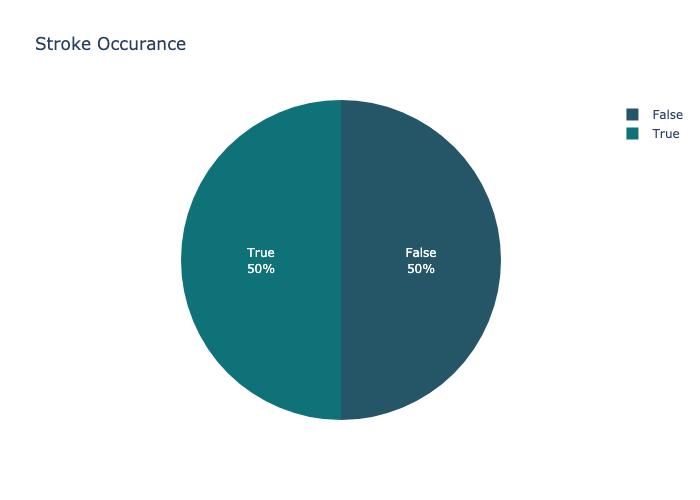

In [35]:
#concatenate upsampled data 
stroke = np.concatenate((stroke0,stroke1))

#create the balanced dataframe
stroke = pd.DataFrame(stroke)
stroke.columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'avg_glucose_level', 'bmi','smoking_status', 'stroke']

# visualize balanced data 
dfstroke = dict(stroke['stroke'].value_counts())
fig = px.pie(names = ['False','True'],values = dfstroke.values(),title = 'Stroke Occurance',color_discrete_sequence=px.colors.sequential.Aggrnyl)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show('png')

In [36]:
stroke

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,3.0,0,0,0,children,0,95.12,18.0,formerly smoked,0
1,1,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0
2,0,8.0,0,0,0,Private,1,110.89,17.6,smokes,0
3,0,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0
4,1,14.0,0,0,0,Never_worked,0,161.28,19.1,formerly smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
9715,0,82.0,1,1,1,Govt_job,1,215.94,27.9,formerly smoked,1
9716,1,75.0,1,0,1,Private,1,221.29,25.8,smokes,1
9717,1,69.0,0,0,1,Private,0,93.81,28.5,formerly smoked,1
9718,1,78.0,0,0,1,Private,0,78.03,23.9,formerly smoked,1


In [37]:
stroke_resampled = pd.get_dummies(stroke, columns =  ['gender','ever_married','work_type','Residence_type','smoking_status'] ,drop_first=True )

In [38]:
stroke_resampled

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_1,ever_married_1,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_1,smoking_status_never smoked,smoking_status_smokes
0,3.0,0,0,95.12,18.0,0,True,False,False,False,False,True,False,False,False
1,58.0,1,0,87.96,39.2,0,True,True,False,True,False,False,True,True,False
2,8.0,0,0,110.89,17.6,0,False,False,False,True,False,False,True,False,True
3,70.0,0,0,69.04,35.9,0,False,True,False,True,False,False,False,False,False
4,14.0,0,0,161.28,19.1,0,True,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9715,82.0,1,1,215.94,27.9,1,False,True,False,False,False,False,True,False,False
9716,75.0,1,0,221.29,25.8,1,True,True,False,True,False,False,True,False,True
9717,69.0,0,0,93.81,28.5,1,True,True,False,True,False,False,False,False,False
9718,78.0,0,0,78.03,23.9,1,True,True,False,True,False,False,False,False,False


In [39]:
x = stroke_resampled.drop('stroke', axis=1)
y = pd.to_numeric(stroke_resampled['stroke'])

In [40]:
scaler = StandardScaler()

x_resampled = scaler.fit_transform(x)

In [41]:
x_train_resampled , x_test_resampled , y_train_resampled , y_test_resampled = train_test_split(x_resampled,y,test_size = .20)

In [42]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11,13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'hamming', 'jaccard', 'minkowski']
}

# Create a K-Nearest Neighbors classifier
knn_classifier = KNeighborsClassifier()

# Create a grid search object with cross-validation
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(x_train_resampled, y_train_resampled)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_knn_classifier = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_knn = best_knn_classifier.predict(x_test_resampled)

# Calculate accuracy and print the classification report
accuracy = accuracy_score(y_test_resampled, y_pred_knn)
print("Best Parameters:", best_params)
print("Accuracy on Test Set:", accuracy)
print("\nClassification Report:\n", classification_report(y_test_resampled, y_pred_knn))


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Accuracy on Test Set: 0.9567901234567902

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       948
           1       0.92      1.00      0.96       996

    accuracy                           0.96      1944
   macro avg       0.96      0.96      0.96      1944
weighted avg       0.96      0.96      0.96      1944



In [43]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Create a Logistic Regression classifier
logistic_classifier = LogisticRegression()

# Create a grid search object with cross-validation
grid_search = GridSearchCV(estimator=logistic_classifier, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(x_train_resampled, y_train_resampled)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_logistic_classifier = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_Lg = best_logistic_classifier.predict(x_test_resampled)

# Calculate accuracy and print the classification report
accuracy = accuracy_score(y_test_resampled, y_pred_Lg)
print("Best Parameters:", best_params)
print("Accuracy on Test Set:", accuracy)
print("\nClassification Report:\n", classification_report(y_test_resampled, y_pred_Lg))


Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Accuracy on Test Set: 0.772633744855967

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.72      0.75       948
           1       0.75      0.83      0.79       996

    accuracy                           0.77      1944
   macro avg       0.78      0.77      0.77      1944
weighted avg       0.77      0.77      0.77      1944



In [44]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
)

grid_search_rf.fit(x_train_resampled, y_train_resampled)

best_params_rf = grid_search_rf.best_params_

best_rf_classifier = RandomForestClassifier(random_state=42, **best_params_rf)
best_rf_classifier.fit(x_train_resampled, y_train_resampled)

y_pred_rf = best_rf_classifier.predict(x_test_resampled)

accuracy_rf_train = best_rf_classifier.score(x_train_resampled, y_train_resampled)
accuracy_rf_test = accuracy_score(y_test_resampled, y_pred_rf)
print("Best Hyperparameters for Random Forest:", best_params_rf)
print(f"Accuracy for Random Forest (Train): {accuracy_rf_train:.4f}")
print(f"Accuracy for Random Forest (Test): {accuracy_rf_test:.4f}")

Best Hyperparameters for Random Forest: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy for Random Forest (Train): 1.0000
Accuracy for Random Forest (Test): 0.9938


In [45]:
param_grid = {
    'criterion' : ['gini', 'enthropy'],
    'max_depth' : [50],
    'min_samples_split' : [2,4,8],
    'min_samples_leaf' : [1,3,5]
}

dt_classifier = DecisionTreeClassifier()

# Create a grid search object with cross-validation
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(x_train_resampled, y_train_resampled)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_dt_classifier = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_dt = best_dt_classifier.predict(x_test_resampled)

# Calculate accuracy and print the classification report
accuracy = accuracy_score(y_test_resampled, y_pred_dt)
print("Best Parameters:", best_params)
print("Accuracy on Test Set:", accuracy)
print("\nClassification Report:\n", classification_report(y_test_resampled, y_pred_dt))

Best Parameters: {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy on Test Set: 0.9758230452674898

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       948
           1       0.95      1.00      0.98       996

    accuracy                           0.98      1944
   macro avg       0.98      0.98      0.98      1944
weighted avg       0.98      0.98      0.98      1944

